![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   


# import

In [544]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

#Библиотека для кодировки категориальных признаков
from sklearn.preprocessing import MultiLabelBinarizer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [545]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [546]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [547]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [548]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [549]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [550]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [551]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [552]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [553]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [554]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [555]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [556]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
31959,id_14190,London,"['Fast Food', 'Asian', 'Vietnamese', 'Soups', ...",14201.0,$,19.0,"[['No frills Vietnamese cafe', 'Good food let ...",/Restaurant_Review-g186338-d8857219-Reviews-An...,d8857219,1,3.0
27214,id_120,Vienna,"['Austrian', 'Central European', 'European', '...",121.0,$$ - $$$,251.0,"[['Classic, with a twist', 'Casual, high quali...",/Restaurant_Review-g190454-d1986351-Reviews-Ga...,d1986351,1,4.5
8869,id_8869,Brussels,"['Italian', 'Mediterranean']",588.0,$$ - $$$,74.0,"[['Beautiful restaurant, wonderful staff', 'An...",/Restaurant_Review-g188644-d4427929-Reviews-IL...,d4427929,0,0.0
28374,id_2508,Lisbon,"['European', 'Portuguese']",2511.0,NaN,4.0,"[[], []]",/Restaurant_Review-g189158-d7727757-Reviews-Po...,d7727757,1,4.5
2722,id_2722,Rome,"['Italian', 'Mediterranean', 'European', 'Vege...",2033.0,$$ - $$$,418.0,"[['A welcome find.', 'Cute place'], ['11/05/20...",/Restaurant_Review-g187791-d4218148-Reviews-Di...,d4218148,0,0.0


In [557]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   


## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [558]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [559]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [560]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)
data['Price Range'] = data['Price Range'].fillna(0)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [561]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

In [562]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [563]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [564]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
20155,id_3218,NaN,3219.0,0,34.0,"[['Very good!!'], ['06/29/2017']]",/Restaurant_Review-g187497-d5870217-Reviews-El...,d5870217,1,4.0,...,0,0,0,0,0,0,0,0,0,0
46333,id_9790,"['Bar', 'British', 'Vegetarian Friendly']",9799.0,$$ - $$$,132.0,"[['Good pub grub, welcoming', 'Great first vis...",/Restaurant_Review-g186338-d2396955-Reviews-Th...,d2396955,1,4.0,...,0,0,0,0,0,0,0,0,0,0
22033,id_499,"['Bar', 'European', 'Vegetarian Friendly']",500.0,$$ - $$$,100.0,"[['Just go', 'Trendy Waterside Spot'], ['08/17...",/Restaurant_Review-g189852-d2341374-Reviews-Or...,d2341374,1,4.0,...,0,0,0,0,0,1,0,0,0,0
21592,id_1260,"['Chinese', 'Seafood', 'Asian', 'Vegetarian Fr...",1263.0,$$ - $$$,74.0,"[['Good solid classics', 'Great meal and servi...",/Restaurant_Review-g188590-d7145971-Reviews-Re...,d7145971,1,4.0,...,0,0,0,0,0,0,0,0,0,0
33045,id_4766,['Italian'],4767.0,$$ - $$$,3.0,"[[], []]",/Restaurant_Review-g187791-d13007353-Reviews-O...,d13007353,1,5.0,...,0,0,0,0,1,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [565]:
data['Price Range'].value_counts()

$$ - $$$    23041
0           17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [566]:
# Ваша обработка 'Price Range'
data['Price Range'] = data['Price Range'].replace("$", 1).replace("$$ - $$$", 2).replace("$$$$", 3)
data['Price Range'] = data['Price Range'].astype('int64')

# EDA 


### Посмотрим распределение признака

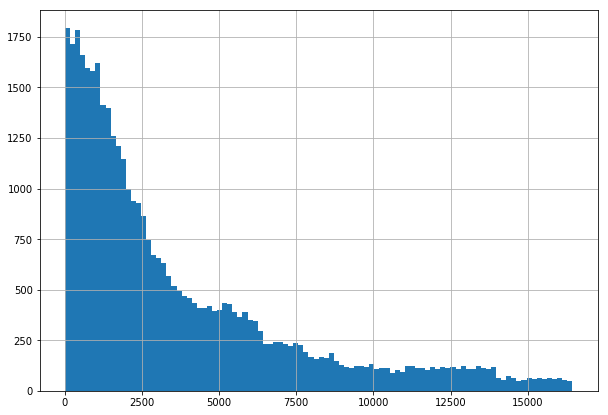

In [567]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

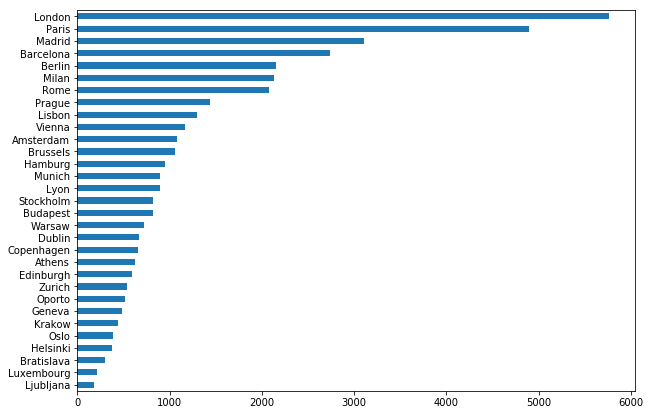

In [568]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

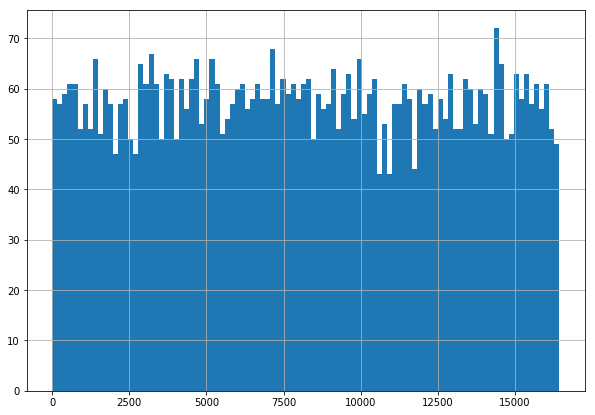

In [569]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

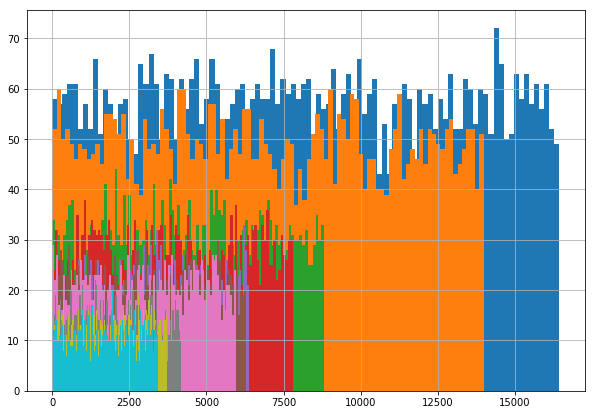

In [570]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Посмотрим распределение целевой переменной

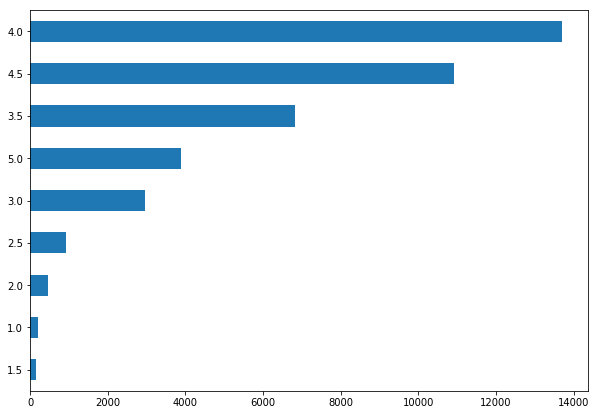

In [571]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

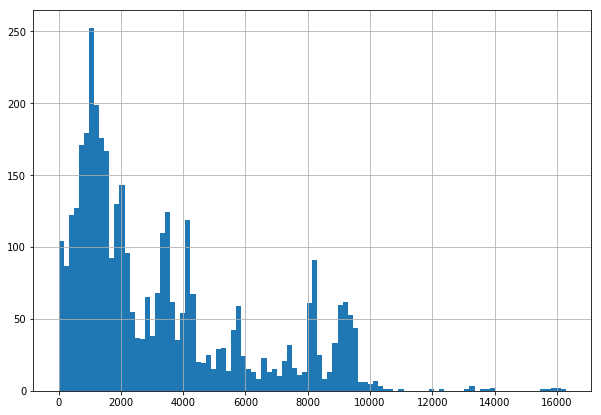

In [572]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

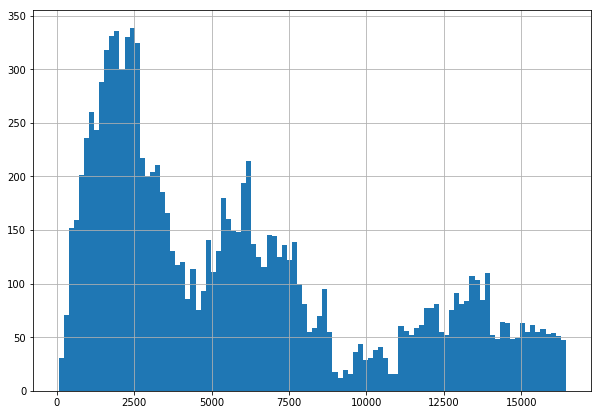

In [573]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

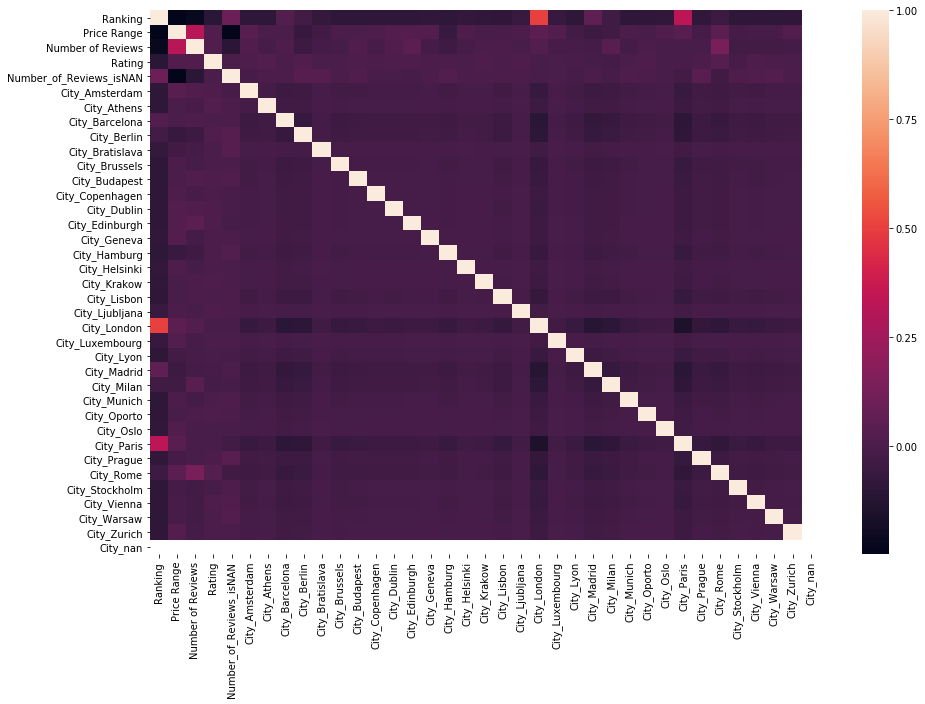

In [574]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [575]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [576]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    #df_output.drop(['Restaurant_id','ID_TA','URL_TA'], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # тут ваш код по обработке NAN
    #df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    #df_output['Cuisine_Style_isNAN'] = pd.isna(df_output['Cuisine Style']).astype('uint8')
    #df_output['Price_Range_isNAN'] = pd.isna(df_output['Price Range']).astype('uint8')
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'] = df_output['Number of Reviews'].fillna(0)
    df_output['Number of Reviews'] = df_output['Number of Reviews'].astype('int64')
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna("['Unknown']")
    df_output['Price Range'] = df_output['Price Range'].fillna(0)
    
    # ################### 3. Feature Engineering ####################################################

    #rest_city - количество ресторанов в городе
    df_output['rest_city'] = df_output['City'].map(df_output.groupby(['City'])['Restaurant_id'].count().to_dict())
    
    # rew_city - количество отзывов в городе
    df_output['rew_city'] = df_output['City'].map(df_output.groupby(['City'])['Number of Reviews'].count().to_dict())
    
    # relative_rank_reviews - отношение ранга ресторана к количеству отзывов в городе
    df_output['relative_rank_reviews'] = df_output['Ranking'] / df_output['rew_city'] 
    
    # relative_rank - отношение ранга ресторана к количеству ресторанов в городе
    df_output['relative_rank'] = df_output['Ranking'] / df_output['rest_city']
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True)
    df_output['Cuisine Style'] = [re.findall(r'\w+\s*\w+\s*\w+', x) for x in df_output['Cuisine Style']]
    df_output['cuisine_count'] = [len(x) for x in df_output['Cuisine Style']]
    df_output['cuisine_count']
    
    # тут ваш код на Encoding фитчей
    
    def get_cuisines(cuisines):
        '''
        Return the list of cuisines from the string for each restaurant
        '''
        cuisines = str(cuisines).replace("[", "").replace("]", "").replace("\'", "").replace("'", "")
        cuisines = cuisines.split(", ")
        return cuisines
    
    def replace_unpopular_cuisines(cuisines):
        '''
        Replace less common kitchens to "Other"
        '''
        c = set(get_cuisines(cuisines))

        shared_cousines=()
        shared_cousines=c.intersection(popular_cusines)

        if len(shared_cousines) != len(c):
            shared_cousines = list(shared_cousines)
            shared_cousines.extend(['Other'])

        return list(shared_cousines)

    # Выбераем популярные значения в Cuisine Style, остальные заменяем на Other
    N = 25  # !!!

    s = df_output['Cuisine Style'].apply(lambda x: get_cuisines(x))
    total_cuisines_list = []
    for x in s:
        total_cuisines_list.extend(x)
    popular_cusines = pd.Series(total_cuisines_list).value_counts()[:N].index
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(
        lambda x: replace_unpopular_cuisines(x))
    
    #Кодируем признак Cuisine Style с помощью MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    df_output = df_output.join(pd.DataFrame(mlb.fit_transform(
        df_output.pop('Cuisine Style')), index=df_output.index, columns=mlb.classes_))
    
    #Создаем dummy-переменную для признака Price Range
    df_output['Price Range'] = df_output['Price Range'].replace("$", 1).replace("$$ - $$$", 2).replace("$$$$", 3)
    df_output['Price Range'] = df_output['Price Range'].astype('int64')
    df_output = pd.get_dummies(df_output, columns=['Price Range'])
    
    
    
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#### Запускаем и проверяем что получилось

In [577]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,rest_city,rew_city,relative_rank_reviews,relative_rank,City_Amsterdam,City_Athens,...,Seafood,Spanish,Sushi,Unknown,Vegan Options,Vegetarian Friendly,Price Range_0,Price Range_1,Price Range_2,Price Range_3
42922,910.0,1426,1,4.0,7193,7193,0.126512,0.126512,0,0,...,1,0,0,0,0,0,0,0,1,0
28728,1746.0,83,1,4.5,3813,3813,0.457907,0.457907,0,0,...,0,0,0,0,0,0,0,0,1,0
12431,4161.0,0,1,5.0,3813,3813,1.091267,1.091267,0,0,...,0,0,0,1,0,0,1,0,0,0
592,1028.0,0,0,0.0,475,475,2.164211,2.164211,0,0,...,0,0,0,1,0,0,1,0,0,0
46590,1421.0,0,1,5.0,1021,1021,1.391773,1.391773,0,0,...,0,0,0,1,0,0,1,0,0,0
42903,10554.0,8,1,4.0,6108,6108,1.727898,1.727898,0,0,...,0,1,0,0,0,0,1,0,0,0
18068,1238.0,45,1,3.5,685,685,1.807299,1.807299,0,0,...,0,0,0,0,0,1,0,1,0,0
9630,489.0,58,0,0.0,6108,6108,0.080059,0.080059,0,0,...,0,0,0,1,0,0,1,0,0,0
27214,121.0,251,1,4.5,1443,1443,0.083853,0.083853,0,0,...,0,0,0,0,0,1,0,0,1,0
1898,5645.0,9,0,0.0,3813,3813,1.480462,1.480462,0,0,...,0,1,0,0,0,0,1,0,0,0


In [578]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 71 columns):
Ranking                  50000 non-null float64
Number of Reviews        50000 non-null int64
sample                   50000 non-null int64
Rating                   50000 non-null float64
rest_city                50000 non-null int64
rew_city                 50000 non-null int64
relative_rank_reviews    50000 non-null float64
relative_rank            50000 non-null float64
City_Amsterdam           50000 non-null uint8
City_Athens              50000 non-null uint8
City_Barcelona           50000 non-null uint8
City_Berlin              50000 non-null uint8
City_Bratislava          50000 non-null uint8
City_Brussels            50000 non-null uint8
City_Budapest            50000 non-null uint8
City_Copenhagen          50000 non-null uint8
City_Dublin              50000 non-null uint8
City_Edinburgh           50000 non-null uint8
City_Geneva              50000 non-null uint8
City_Hamb

In [579]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [580]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [581]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 70), (40000, 70), (40000, 69), (32000, 69), (8000, 69))

# Model 
Сам ML

In [582]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [583]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [584]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [585]:
#  Т.к рейтинг представлен с шагом в 0.5, то мы тоже округлим наши предсказания.
# Напишем для этого функцию.
def round_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

In [586]:
# Теперь округлим полученные значения.
for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [587]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1761875


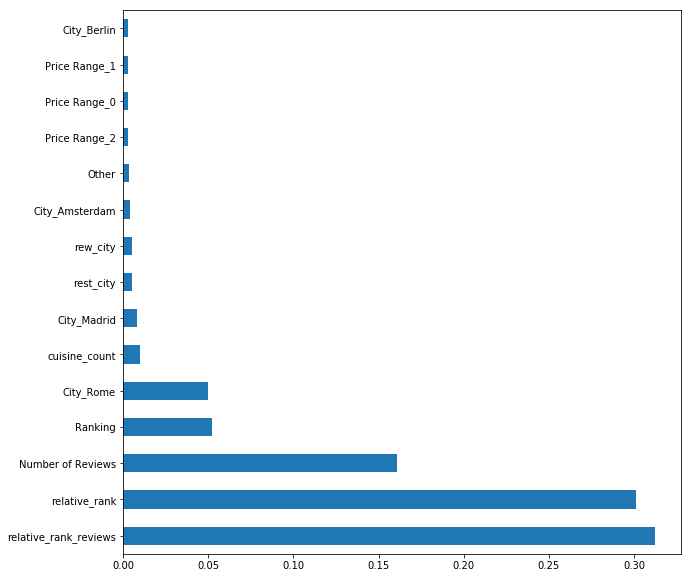

In [588]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [589]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,rest_city,rew_city,relative_rank_reviews,relative_rank,City_Amsterdam,City_Athens,City_Barcelona,...,Seafood,Spanish,Sushi,Unknown,Vegan Options,Vegetarian Friendly,Price Range_0,Price Range_1,Price Range_2,Price Range_3
3237,16175.0,2,0.0,7193,7193,2.248714,2.248714,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7302,990.0,79,0.0,1443,1443,0.686071,0.686071,0,0,0,...,0,0,0,0,0,1,0,0,1,0
8580,288.0,520,0.0,7193,7193,0.040039,0.040039,0,0,0,...,0,0,0,0,1,1,0,0,0,1
3665,107.0,228,0.0,3813,3813,0.028062,0.028062,0,0,0,...,0,0,0,0,1,1,0,0,1,0
4559,2383.0,15,0.0,1126,1126,2.116341,2.116341,0,0,0,...,0,0,0,1,0,0,1,0,0,0
9862,2604.0,16,0.0,1314,1314,1.981735,1.981735,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2838,729.0,784,0.0,6108,6108,0.119352,0.119352,0,0,0,...,0,0,0,0,0,1,0,1,0,0
6472,730.0,426,0.0,1372,1372,0.532070,0.532070,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1017,917.0,2,0.0,925,925,0.991351,0.991351,0,0,0,...,0,0,0,1,0,0,1,0,0,0
5351,3150.0,60,0.0,7193,7193,0.437926,0.437926,0,0,0,...,0,0,0,0,1,1,0,0,1,0


In [590]:
test_data = test_data.drop(['Rating'], axis=1)

In [591]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [592]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [593]:
predict_submission

array([3.05 , 4.27 , 4.5  , ..., 3.045, 4.5  , 4.25 ])

In [594]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.050
1,id_1,4.270
2,id_2,4.500
3,id_3,4.270
4,id_4,4.425
5,id_5,4.605
6,id_6,2.990
7,id_7,2.185
8,id_8,4.110
9,id_9,4.660


# Вывод

* Улучшенные навыки работы с Pandas
* Пробовал работать в блокноте kaggle
* Улучшены навыки предварительной обработки
* Практивковался в кодировании и создании новых признаков

Проверка MAE:  0.1761875